In [1]:
import cell_movie_maker as cmm
import matplotlib.pyplot as plt
import pathlib


from IPython.display import display
import IPython.display


# Configuration
It is useful to configure cell-movie-maker with some folders so to help it automatically find simulations and store outputs to sensible places  

Configurations are stored in a `Singleton` type structure i.e. there is exactly one configuration for each Python runtime.  

NOTE: Due to issues with ffmpeg, if the path to the output_folder has '-' or ' ' characters I encounter issues.  

In [2]:
# Folder CHASTE is configured to write to
cmm.Config.simulations_folder = pathlib.Path("chaste_output")

# By default where to store analysis results
cmm.Config.output_folder = pathlib.Path("analysis_output")

# Optional: Link cell-movie-maker to a database which has simulation metadata stored.
# This requires chaste-simulation-database-connector to be installed
if False:
    cmm.Config.set_simulation_database(pathlib.Path("analysis_output", "TCellABM.db"))

# Structure of CHASTE data in cell-movie-maker

cell-movie-maker has `dataclasses` which organise CHASTE simulation data.  
The highest level is `Experiment`, which stores a collection of CHASTE simulations. This will usually be the simulations from a parameter sweep.  

The individual CHASTE simulations are stored in the `Simulation` class. This can be subclassed for alternative models (e.g. `MacrophageSimulation`)

From each `Simulation` we can retrieve the saved timepoints, these are stored as a `SimulationTimepoint`. `SimulationTimepoint` can also be subclassed for alternative models (e.g. `MacrophageSimulationTimepoint`)

## Loading Experiments

In [3]:
# Create experiment given exact path
experiment = cmm.Experiment(pathlib.Path("chaste-output", "TCellABM"))

# Load experiment by name. This will search for the experiment in `cmm.Config.simulations_folder``
experiment = cmm.load_experiment('TCellABM')
# Note this uses factory pattern in case Experiment is subclassed for specific models
# e.g. experiment = cmm.load_experiment('TCellABM', cls=cmm.Experiment)
print(f"Found experiment folder: {experiment.experiment_folder}")

Found experiment folder: chaste-output/TCellABM


Check what sims are part of the experiment (in this case only 1)

In [4]:
print(f"Found sim_ids: {experiment.sim_ids}")
print(f"In folders: {experiment.sim_folders}")

Found sim_ids: [1520]
In folders: [PosixPath('chaste-output/TCellABM/sim_1520/results_from_time_0')]


## Retrieving Simulations

In [5]:
# Read simulation given exact path
simulation = cmm.Simulation(pathlib.Path("chaste-output", "TCellABM", "sim_1520", "results_from_time_0"))

# Load simulation from experiment given sim_id
simulation = experiment.read_simulation(1520)

# Through slight trickery we can also read simulations using indices / slice notation
# List of all simulations
simulations = experiment.simulations[:]
# Get zeroth simulation
simulation = experiment.simulations[0]

print(f"Simulation folder: {simulation.results_folder}")
print(f"Name: {simulation.name}, ID: {simulation.id}, Iteration: {simulation.iteration}")
print(f"Sample of saved timesteps: {simulation.results_timesteps[::10]}")

Simulation folder: chaste-output/TCellABM/sim_1520/results_from_time_0
Name: TCellABM, ID: sim_1520, Iteration: 1520
Sample of saved timesteps: [0, 6000, 12000, 18000, 24000, 30000, 36000, 42000, 48000, 54000, 60000]


Most of the time `experiment.read_simulation(sim_id)` is the most useful.  
Alternatives are sometimes useful  

## Retrieving SimulationTimepoints

In [6]:
# Simulation parameters
IPython.display.display_pretty(simulation.parameters.keys())

dict_keys(['ACCD_S', 'ACCD_T', 'AngiogenesisDelay', 'AngiogenesisRadius', 'CCL5CD8Sensitivity', 'CCL5ConsumptionCoefficient', 'CCL5DecayRate', 'CCL5DiffusionCoefficient', 'CCL5DuDtCoefficient', 'CCL5ExtravasationThreshold', 'CCL5InitialSolutionFile', 'CCL5PDEStepSize', 'CCL5SourceCoefficient', 'CD8DiffusionCoefficient', 'CD8InitialPotency', 'CD8MinPotency', 'CXCL9ConcHalfMaximalForce', 'CXCL9ConsumptionCoefficient', 'CXCL9DecayRate', 'CXCL9DiffusionCoefficient', 'CXCL9DuDtCoefficient', 'CXCL9InitialSolutionFile', 'CXCL9PDEStepSize', 'CXCL9SourceCoefficient', 'ConfigurationSeed', 'DTBV', 'DamageThreshold', 'DampingConstant', 'DecayRateInECMMultiplier', 'ECMDensityDampingMultiplier', 'ECMDensityFrictionMultiplier', 'EndTime', 'Flag', 'FrictionStrength', 'HEIGHT', 'ID', 'IFNgConcHalfMaximalCXCL9', 'IFNgConsumptionCoefficient', 'IFNgDecayRate', 'IFNgDiffusionCoefficient', 'IFNgDuDtCoefficient', 'IFNgInitialSolutionFile', 'IFNgPDEStepSize', 'IFNgSourceCoefficient', 'IT', 'InitialMacrophageC

In [7]:
# Multiple ways for getting timepoints

# Read SimulationTimepoint at t=30000
timepoint = simulation.read_timepoint(30000)

# We can access timepoints as if they were a list of them inside the simulation
# This lets us use index / slice notation to retrieve timepoints.
# NOTE: Through trickery this is not memory intensive, the requested simulations are read on request
# Example uses:
# Get every 10 timepoints
timepoints = simulation.timepoints[::10]
# Get first timepoint
timepoint = simulation.timepoints[0]
# Get final timepoint
timepoint = simulation.timepoints[-1]

## What is stored in a timepoint?

In [8]:
# Basic Info
print(f'Name: {timepoint.name}, ID: {timepoint.id}, timestep: {timepoint.timestep}')
# Cell Data
display(timepoint.data.sample(5, random_state=42))

# For specific models helper functions can be added to timepoints to retrieve a subset of `timepoint.data` e.g.
# Blood vessels
print(f'{len(timepoint.blood_vessel_data)} blood vessels')
# T-Cells
print(f'{len(timepoint.cytotoxic_data)} T-cells')
# Tumour
print(f'{len(timepoint.tumour_data)} tumour cells')

Name: TCellABM, ID: sim_1520, timestep: 60000


,x,y,z,volume,radius,Ages,potency,damage,oxygen,ccl5,cxcl9,ifn-gamma,density,cell_type,damping_coefficient,friction,pressure,target_radius,tissue_stress
905,13.618998,58.798738,0.0,0.341813,0.329852,189.400000,0.384511,NaN,0.922547,0.438602,0.0,0.322995,0.0,T Cell,1.0,0.625,2.403499,0.4,1.753699e-01
3254,13.247003,87.136437,0.0,0.502655,0.400000,29.258333,0.500000,NaN,0.874640,0.188585,0.0,0.062051,0.0,T Cell,1.0,0.625,0.000000,0.4,-2.220446e-16
2318,34.110282,21.263383,0.0,0.502655,0.400000,83.441667,0.500000,NaN,0.792075,0.514508,0.0,0.416100,0.0,T Cell,1.0,0.625,0.000000,0.4,-2.220446e-16
1164,66.271842,43.438258,0.0,0.502655,0.400000,165.108333,0.434063,NaN,0.219821,0.613679,0.0,0.705657,0.0,T Cell,1.0,0.625,0.000000,0.4,-2.220446e-16
1600,27.036108,62.499566,0.0,0.502655,0.400000,131.058333,0.434063,NaN,0.416731,0.485306,0.0,0.595030,0.0,T Cell,1.0,0.625,2.097374,0.4,-2.220446e-16


204 blood vessels
3484 T-cells
32 tumour cells


### PDE Outputs
For details of this see the `SimulationTimepoint` implementation.  
`SimulationTimepoint` should be subclassed for each model to make retrieving PDE data easier.  
e.g. for TCellABM we can read PDEs

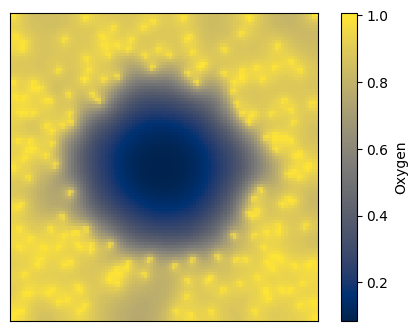

In [9]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

ax.set_aspect(1)
ax.set_xticks([])
ax.set_yticks([])

cm = ax.pcolormesh(timepoint.oxygen_data, cmap='cividis')
fig.colorbar(cm, ax=ax, label='Oxygen')

plt.show(fig)
plt.close(fig)

# Note on Parallelism
Framework enables running analysis on all simulation timepoints in parallel.  
Useful to know this exists. However shouldn't usually have to use this low level implementation.  
Instead use other classes which make heavy use of this parallelism functionality.    

## Running some function on multiple timepoints of a simulation

Sample function which simply returns number of cells at a given timepoint.

Function will be applied to each timepoint and can return analysis.  
To use framework to do this, function should follow this pattern

In [10]:
def process_some_timepoint(args:tuple[cmm.Simulation,cmm.SimulationTimepoint,int]):
    sim, tp, frame_number = args
    
    # Return number of tumour cells in the timepoint
    return len(tp.tumour_data)

Apply this function to every timepoint.  
This lets us plot a trajectory (NOTE: this is an example, not recommended way to get cellcounts)

101it [00:00, 885.64it/s]            


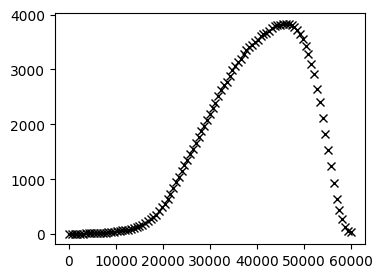

In [11]:
n_tumour = simulation.for_timepoint_single_thread(process_some_timepoint, start=0, stop=None, step=1)

fig, ax = plt.subplots(1,1, figsize=(4,3))
ax.plot(simulation.results_timesteps, n_tumour, 'kx')
plt.show(fig)
plt.close(fig)

Can apply this function to each timepoint in parallel.  
NOTE Due to python having GIL, this uses multiprocessing (not multithreading).  

100%|██████████| 101/101 [00:00<00:00, 536.10it/s]


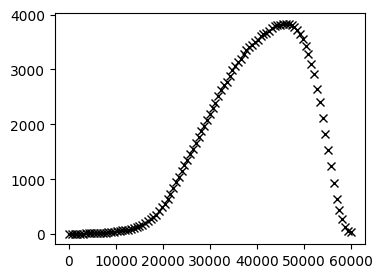

In [12]:
n_tumour = simulation.for_timepoint(process_some_timepoint, start=0, stop=None, step=1)

fig, ax = plt.subplots(1,1, figsize=(4,3))
ax.plot(simulation.results_timesteps, n_tumour, 'kx')
plt.show(fig)
plt.close(fig)